INFORMASI DATASET
Path Dataset: /home/fadhli/S2/facedet/dataset/original_dataset
Jumlah Kelas: 10
--------------------------------------------------------------------------------
1. Eczema 1677: 1677 gambar
10. Warts Molluscum and other Viral Infections - 2103: 2103 gambar
2. Melanoma 15.75k: 3140 gambar
3. Atopic Dermatitis - 1.25k: 1257 gambar
4. Basal Cell Carcinoma (BCC) 3323: 3323 gambar
5. Melanocytic Nevi (NV) - 7970: 7970 gambar
6. Benign Keratosis-like Lesions (BKL) 2624: 2079 gambar
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 2055 gambar
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1847 gambar
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1702 gambar
--------------------------------------------------------------------------------
Total Gambar: 27,153
Rata-rata per Kelas: 2715.30
Minimum: 1257
Maximum: 7970

ANALISIS KESEIMBANGAN DATA

Ringkasan Persentase:
-----------------------------------------------------------------------

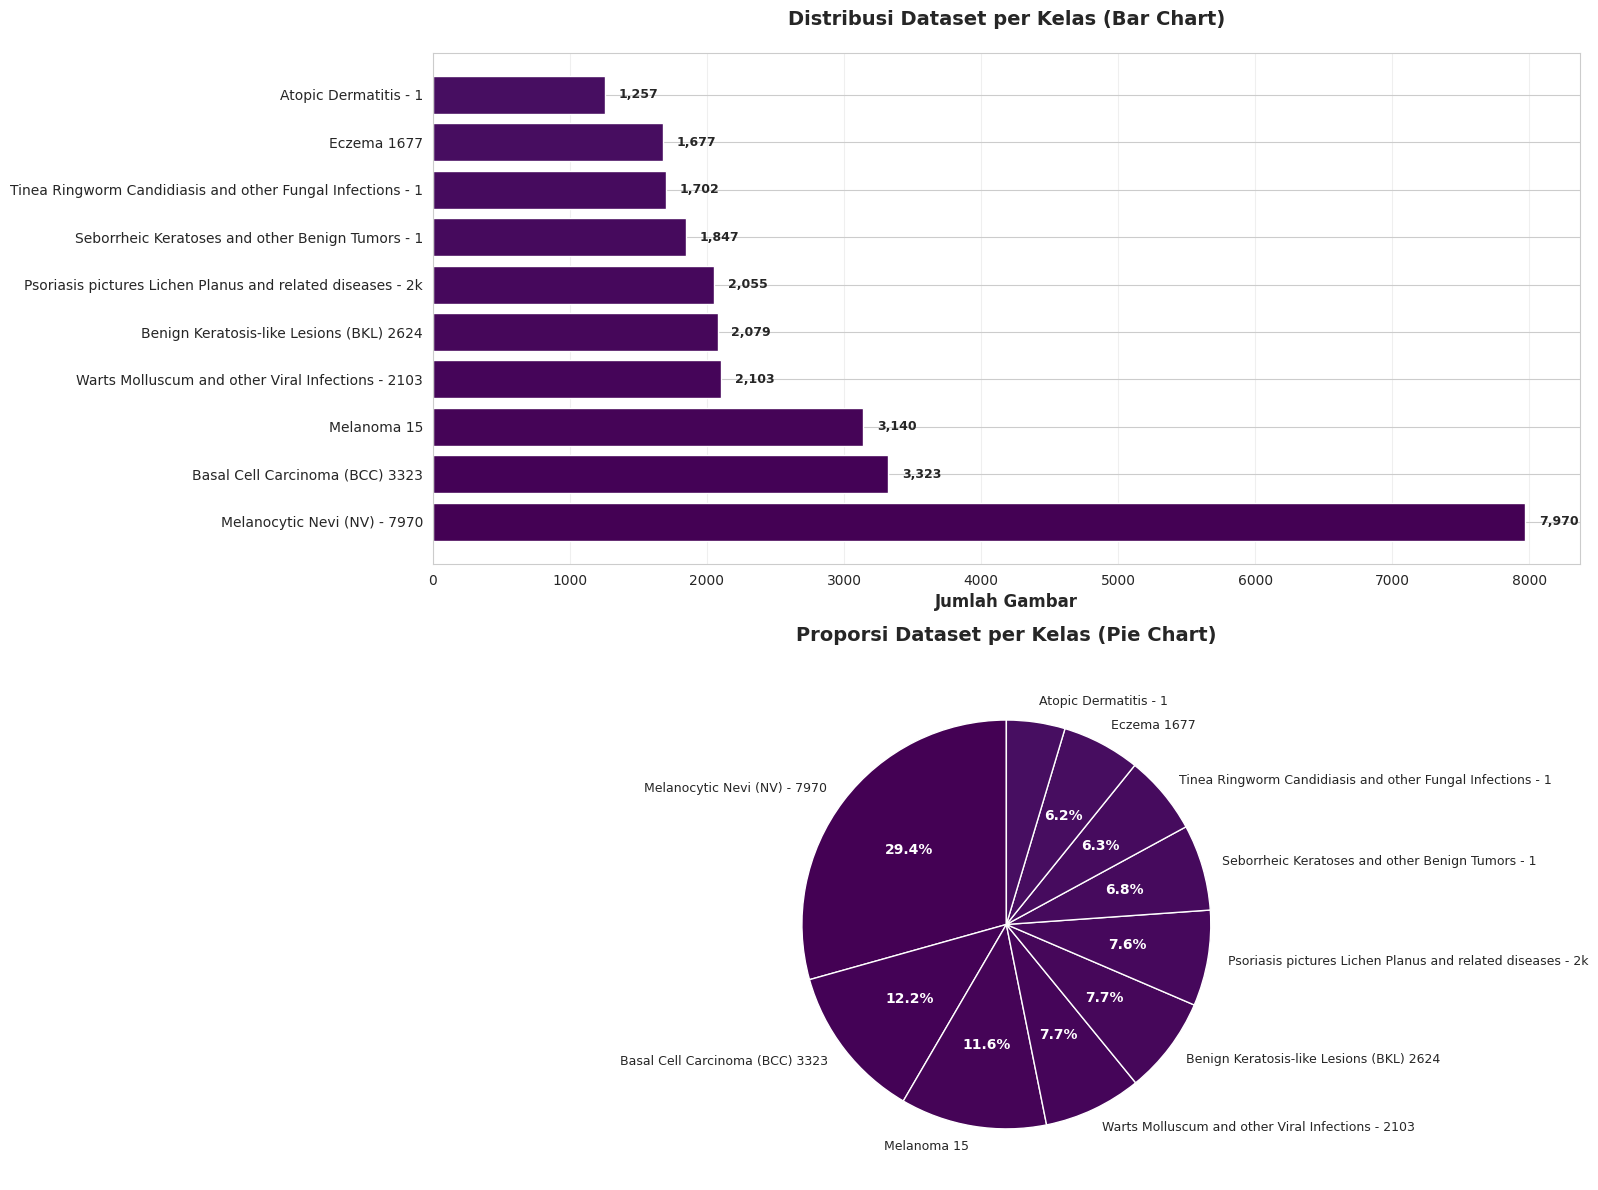


✓ Ringkasan dataset disimpan di: dataset_summary.csv


In [4]:
## Check Data Original
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set encoding untuk Windows console (hanya jika bukan Jupyter Notebook)
if sys.platform == 'win32' and hasattr(sys.stdout, 'buffer'):
    import io
    sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8')

# Set style untuk visualisasi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Path ke dataset
# DATASET_PATH = Path("dataset/praproses_result/final_images")
DATASET_PATH = Path("dataset/original_dataset")

def load_dataset_info():
    """
    Mengimport dataset dan menghitung jumlah gambar di setiap folder
    """
    dataset_info = []
    
    # Mendapatkan semua folder kelas
    class_folders = [f for f in DATASET_PATH.iterdir() if f.is_dir()]
    
    print("=" * 80)
    print("INFORMASI DATASET")
    print("=" * 80)
    print(f"Path Dataset: {DATASET_PATH.absolute()}")
    print(f"Jumlah Kelas: {len(class_folders)}")
    print("-" * 80)
    
    # Menghitung jumlah file di setiap kelas
    for folder in sorted(class_folders):
        # Hitung jumlah file gambar
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        image_files = [f for f in folder.iterdir() 
                      if f.is_file() and f.suffix.lower() in image_extensions]
        
        count = len(image_files)
        class_name = folder.name
        
        dataset_info.append({
            'Kelas': class_name,
            'Jumlah Gambar': count,
            'Path': str(folder)
        })
        
        print(f"{class_name}: {count} gambar")
    
    # Buat DataFrame
    df = pd.DataFrame(dataset_info)
    
    # Statistik keseluruhan
    total_images = df['Jumlah Gambar'].sum()
    avg_images = df['Jumlah Gambar'].mean()
    min_images = df['Jumlah Gambar'].min()
    max_images = df['Jumlah Gambar'].max()
    
    print("-" * 80)
    print(f"Total Gambar: {total_images:,}")
    print(f"Rata-rata per Kelas: {avg_images:.2f}")
    print(f"Minimum: {min_images}")
    print(f"Maximum: {max_images}")
    print("=" * 80)
    
    return df

def visualize_distribution(df):
    """
    Membuat visualisasi penyebaran data
    """
    # Persiapan data untuk visualisasi
    # Bersihkan nama kelas untuk tampilan yang lebih baik
    df_sorted = df.sort_values('Jumlah Gambar', ascending=False).copy()
    
    # Buat singkatan nama kelas untuk sumbu X
    df_sorted['Kelas_Singkat'] = df_sorted['Kelas'].apply(
        lambda x: x.split('.')[1].strip() if '.' in x else x
    )
    
    # Create subplot dengan 2 baris
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Plot 1: Bar chart horizontal dengan warna gradient
    colors = plt.cm.viridis(range(len(df_sorted)))
    bars = axes[0].barh(range(len(df_sorted)), df_sorted['Jumlah Gambar'], color=colors)
    axes[0].set_yticks(range(len(df_sorted)))
    axes[0].set_yticklabels(df_sorted['Kelas_Singkat'], fontsize=10)
    axes[0].set_xlabel('Jumlah Gambar', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribusi Dataset per Kelas (Bar Chart)', 
                     fontsize=14, fontweight='bold', pad=20)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Tambahkan label nilai di setiap bar
    for i, (bar, count) in enumerate(zip(bars, df_sorted['Jumlah Gambar'])):
        axes[0].text(count + 100, i, f'{count:,}', 
                    va='center', fontsize=9, fontweight='bold')
    
    # Plot 2: Pie chart
    # Hanya tampilkan label untuk kelas dengan > 5% data
    total = df_sorted['Jumlah Gambar'].sum()
    percentages = (df_sorted['Jumlah Gambar'] / total) * 100
    
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 5 else ''
    
    wedges, texts, autotexts = axes[1].pie(
        df_sorted['Jumlah Gambar'], 
        labels=df_sorted['Kelas_Singkat'],
        autopct=autopct_format,
        startangle=90,
        colors=colors,
        textprops={'fontsize': 9}
    )
    
    # Perbaiki tampilan teks
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    axes[1].set_title('Proporsi Dataset per Kelas (Pie Chart)', 
                     fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Simpan visualisasi
    output_path = "dataset_distribution.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualisasi disimpan di: {output_path}")
    
    plt.show()

def check_data_balance(df):
    """
    Mengecek keseimbangan dataset
    """
    print("\n" + "=" * 80)
    print("ANALISIS KESEIMBANGAN DATA")
    print("=" * 80)
    
    total = df['Jumlah Gambar'].sum()
    
    # Hitung persentase setiap kelas
    df_analysis = df.copy()
    df_analysis['Persentase (%)'] = (df_analysis['Jumlah Gambar'] / total * 100).round(2)
    df_analysis = df_analysis.sort_values('Jumlah Gambar', ascending=False)
    
    print("\nRingkasan Persentase:")
    print("-" * 80)
    for idx, row in df_analysis.iterrows():
        class_name = row['Kelas'].split('.')[1].strip() if '.' in row['Kelas'] else row['Kelas']
        print(f"{class_name:50s} {row['Jumlah Gambar']:6,} ({row['Persentase (%)']:5.2f}%)")
    
    # Deteksi imbalance
    max_pct = df_analysis['Persentase (%)'].max()
    min_pct = df_analysis['Persentase (%)'].min()
    ratio = max_pct / min_pct
    
    print("-" * 80)
    print(f"Rasio Imbalance: {ratio:.2f}:1")
    
    if ratio > 10:
        print("⚠️  Dataset SANGAT TIDAK SEIMBANG - Pertimbangkan teknik resampling")
    elif ratio > 5:
        print("⚠️  Dataset TIDAK SEIMBANG - Mungkin perlu augmentasi")
    elif ratio > 2:
        print("ℹ️  Dataset agak tidak seimbang - Masih dalam batas wajar")
    else:
        print("✓ Dataset relatif seimbang")
    
    print("=" * 80)
    
    return df_analysis

def main():
    """
    Fungsi utama untuk menjalankan semua analisis
    """
    # Cek apakah folder dataset ada
    if not DATASET_PATH.exists():
        print(f"❌ Error: Folder {DATASET_PATH} tidak ditemukan!")
        return
    
    # Load dan tampilkan info dataset
    df = load_dataset_info()
    
    # Analisis keseimbangan
    df_analysis = check_data_balance(df)
    
    # Visualisasi distribusi
    visualize_distribution(df)
    
    # Simpan ringkasan ke CSV
    output_csv = "dataset_summary.csv"
    df_analysis.to_csv(output_csv, index=False)
    print(f"\n✓ Ringkasan dataset disimpan di: {output_csv}")

if __name__ == "__main__":
    main()


In [ ]:
# Pra-Processing
"""
========================================================================================
SCRIPT PREPROCESSING IMAGE UNTUK KLASIFIKASI PENYAKIT KULIT - OPTIMIZED VERSION
========================================================================================
Perbaikan:
- Skip tahap yang sudah selesai
- Batch processing untuk normalization (mencegah OOM)
- Checkpoint system untuk resume
- GPU acceleration support
========================================================================================
"""

import os
import sys
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import argparse
import json
import gc  # Garbage collection untuk memory optimization

# Augmentation imports
import albumentations as A
from albumentations.core.composition import Compose

# Konfigurasi Output
import warnings
warnings.filterwarnings('ignore')

# ========================================================================================
# GPU DETECTION
# ========================================================================================

def check_gpu_availability():
    """Cek ketersediaan GPU untuk OpenCV"""
    try:
        cuda_available = cv2.cuda.getCudaEnabledDeviceCount() > 0
        if cuda_available:
            device_count = cv2.cuda.getCudaEnabledDeviceCount()
            print(f"✅ GPU terdeteksi: {device_count} CUDA device(s) tersedia")
            return True
        else:
            print("ℹ️  GPU tidak terdeteksi, menggunakan CPU")
            return False
    except:
        print("ℹ️  OpenCV tidak di-build dengan CUDA support, menggunakan CPU")
        return False

USE_GPU = False

# ========================================================================================
# KONFIGURASI GLOBAL
# ========================================================================================

class Config:
    """Konfigurasi untuk preprocessing"""
    
    # Path dataset
    INPUT_DIR = Path("dataset/original_dataset")
    OUTPUT_DIR = Path("dataset/praproses_result")
    
    # Parameter preprocessing
    TARGET_SIZE = (224, 224)
    
    # Denoising parameters
    DENOISE_H = 10
    DENOISE_H_COLOR = 10
    DENOISE_TEMPLATE_SIZE = 7
    DENOISE_SEARCH_SIZE = 21
    
    # CLAHE parameters
    CLAHE_CLIP_LIMIT = 2.0
    CLAHE_TILE_SIZE = (8, 8)
    
    # Augmentation parameters
    AUGMENTATION_ENABLED = True
    AUGMENTATION_FACTOR = 2
    
    # Balanced Augmentation parameters
    BALANCED_AUGMENTATION_ENABLED = True
    BALANCING_STRATEGY = 'balanced'  # 'max', 'balanced', 'median'
    TARGET_IMAGES_PER_CLASS = None  # None = auto calculate, or set manual number
    
    # Normalization parameters
    NORMALIZE_MEAN = [0.485, 0.456, 0.406]
    NORMALIZE_STD = [0.229, 0.224, 0.225]
    
    # Class balancing at normalization stage
    # Set to False if augmentation already balanced the dataset
    APPLY_BALANCING_AT_NORMALIZATION = False  # Skip balancing if augmentation already balanced
    
    # Batch processing parameters (untuk mencegah OOM)
    BATCH_SIZE = 500  # Jumlah gambar per batch (reduced for memory optimization)
    
    # Checkpoint parameters
    CHECKPOINT_FILE = OUTPUT_DIR / "normalization_checkpoint.json"
    
    # Skip control
    SKIP_COMPLETED = True  # Auto skip tahap yang sudah selesai
    FORCE_RERUN = False    # Paksa rerun semua tahap


# ========================================================================================
# HELPER FUNCTIONS
# ========================================================================================

def is_stage_completed(output_dir, min_images=100):
    """Cek apakah tahap preprocessing sudah selesai"""
    if not output_dir.exists():
        return False
    
    total_images = 0
    for class_folder in output_dir.iterdir():
        if class_folder.is_dir():
            image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                          list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
            total_images += len(image_files)
    
    return total_images >= min_images


def count_images_in_dir(directory):
    """Hitung total gambar dalam direktori"""
    total = 0
    for class_folder in directory.iterdir():
        if class_folder.is_dir():
            image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                          list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
            total += len(image_files)
    return total


def normalize_image(image):
    """Normalisasi gambar menggunakan ImageNet mean dan std"""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_float = image_rgb.astype(np.float32) / 255.0
    mean = np.array(Config.NORMALIZE_MEAN, dtype=np.float32)
    std = np.array(Config.NORMALIZE_STD, dtype=np.float32)
    normalized = (image_float - mean) / std
    return normalized


def get_memory_usage():
    """Get current memory usage in MB"""
    import psutil
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convert to MB


def balance_dataset(all_image_paths, all_labels, class_names):
    """
    Balance dataset using random undersampling.
    Each class will have the same number of samples as the smallest class.
    
    Args:
        all_image_paths: List of all image paths
        all_labels: List of corresponding labels
        class_names: List of class names
    
    Returns:
        balanced_paths: Balanced list of image paths
        balanced_labels: Balanced list of labels
        balancing_stats: Statistics about the balancing process
    """
    print("\n" + "="*80)
    print("⚖️  CLASS BALANCING - Random Undersampling")
    print("="*80)
    
    # Group paths by class
    class_images = {}
    for path, label in zip(all_image_paths, all_labels):
        if label not in class_images:
            class_images[label] = []
        class_images[label].append(path)
    
    # Print distribution before balancing
    print("\n📊 Distribution BEFORE balancing:")
    for label, paths in sorted(class_images.items()):
        class_name = class_names[label]
        print(f"   {class_name}: {len(paths):,} images")
    
    # Find minimum class size
    min_size = min(len(paths) for paths in class_images.values())
    print(f"\n🎯 Target size per class: {min_size:,} images")
    
    # Randomly sample from each class
    np.random.seed(42)  # For reproducibility
    balanced_paths = []
    balanced_labels = []
    
    balancing_stats = {
        'min_class_size': min_size,
        'before': {},
        'after': {},
        'removed': {}
    }
    
    print("\n📊 Distribution AFTER balancing:")
    for label, paths in sorted(class_images.items()):
        class_name = class_names[label]
        original_count = len(paths)
        
        # Random sampling
        sampled_indices = np.random.choice(len(paths), size=min_size, replace=False)
        sampled_paths = [paths[i] for i in sampled_indices]
        
        balanced_paths.extend(sampled_paths)
        balanced_labels.extend([label] * min_size)
        
        removed = original_count - min_size
        print(f"   {class_name}: {min_size:,} images (removed {removed:,})")
        
        balancing_stats['before'][class_name] = original_count
        balancing_stats['after'][class_name] = min_size
        balancing_stats['removed'][class_name] = removed
    
    # Shuffle the balanced dataset
    combined = list(zip(balanced_paths, balanced_labels))
    np.random.shuffle(combined)
    balanced_paths, balanced_labels = zip(*combined)
    balanced_paths = list(balanced_paths)
    balanced_labels = list(balanced_labels)
    
    total_before = sum(balancing_stats['before'].values())
    total_after = len(balanced_paths)
    total_removed = total_before - total_after
    
    print(f"\n📈 Summary:")
    print(f"   Before: {total_before:,} images")
    print(f"   After:  {total_after:,} images")
    print(f"   Removed: {total_removed:,} images ({total_removed/total_before*100:.1f}%)")
    print("="*80)
    
    balancing_stats['total_before'] = total_before
    balancing_stats['total_after'] = total_after
    balancing_stats['total_removed'] = total_removed
    
    return balanced_paths, balanced_labels, balancing_stats


def get_augmentation_pipeline():
    """
    Buat augmentation pipeline menggunakan albumentation
    """
    return A.Compose([
        A.OneOf([
            A.Rotate(limit=15, p=1.0),
            A.HorizontalFlip(p=1.0),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.RandomScale(scale_limit=0.1, p=1.0),
        ], p=1.0)
    ])


def balance_dataset_via_augmentation(input_dir, output_dir, strategy='balanced', target_per_class=None):
    """
    Augmentasi adaptif untuk menyeimbangkan dataset.
    
    Args:
        input_dir: Path direktori input dengan subdirektori per kelas
        output_dir: Path direktori output
        strategy: 'max', 'balanced', atau 'median' untuk menentukan target
        target_per_class: Target manual jumlah gambar per kelas (opsional)
    
    Returns:
        Dictionary berisi statistik proses balancing
    """
    print("\n" + "="*80)
    print("⚖️  BALANCED AUGMENTATION - Adaptive Strategy")
    print("="*80)
    
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Hitung distribusi kelas saat ini
    class_counts = {}
    class_folders = sorted([f for f in input_path.iterdir() if f.is_dir()])
    
    print("\n📊 Current class distribution:")
    for class_folder in class_folders:
        class_name = class_folder.name
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        count = len(image_files)
        class_counts[class_name] = count
        print(f"   {class_name}: {count:,} images")
    
    # Tentukan target per kelas
    if target_per_class is None:
        counts = list(class_counts.values())
        if strategy == 'max':
            target = max(counts)
        elif strategy == 'median':
            target = int(np.median(counts))
        else:  # 'balanced' - gunakan mean
            target = int(np.mean(counts))
    else:
        target = target_per_class
    
    print(f"\n🎯 Target per class: {target:,} images (strategy: {strategy})")
    
    # Setup augmentation pipeline
    augment = get_augmentation_pipeline()
    
    # Process setiap kelas
    total_original = 0
    total_augmented = 0
    
    for class_folder in tqdm(class_folders, desc="Processing classes"):
        class_name = class_folder.name
        output_class_dir = output_path / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Ambil semua gambar di kelas ini
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        current_count = len(image_files)
        total_original += current_count
        
        # Hitung berapa banyak augmentasi/undersampling yang diperlukan
        needed = target - current_count
        
        # Copy gambar original HANYA jika needed >= 0 (butuh augmentasi atau sudah pas)
        # Jika needed < 0, kita akan undersample langsung tanpa copy dulu
        if needed >= 0:
            for img_path in image_files:
                shutil.copy2(img_path, output_class_dir / img_path.name)
        
        if needed > 0:
            print(f"\n   {class_name}: Need {needed:,} more images (augmentation)")
            
            # Generate augmented images
            aug_count = 0
            while aug_count < needed:
                # Pilih gambar secara random untuk di-augment
                source_img_path = np.random.choice(image_files)
                
                try:
                    # Load image
                    image = cv2.imread(str(source_img_path))
                    if image is None:
                        continue
                    
                    # Apply augmentation
                    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    augmented = augment(image=image_rgb)
                    augmented_image = augmented['image']
                    augmented_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                    
                    # CRITICAL: Resize kembali ke target size setelah augmentasi
                    # karena beberapa transformasi (seperti RandomScale) bisa mengubah ukuran
                    augmented_bgr = cv2.resize(augmented_bgr, Config.TARGET_SIZE, interpolation=cv2.INTER_AREA)
                    
                    # Save augmented image
                    aug_filename = f"{source_img_path.stem}_aug_{aug_count:04d}{source_img_path.suffix}"
                    aug_path = output_class_dir / aug_filename
                    cv2.imwrite(str(aug_path), augmented_bgr)
                    
                    aug_count += 1
                    total_augmented += 1
                    
                except Exception as e:
                    print(f"\n   ⚠️ Error augmenting {source_img_path.name}: {str(e)}")
                    continue
        
        elif needed < 0:
            # Jika lebih dari target, lakukan random undersampling
            print(f"\n   {class_name}: Has {current_count:,} images, need to remove {-needed:,} (undersampling)")
            
            # Random sampling untuk memilih gambar yang akan disimpan
            np.random.seed(42)  # For reproducibility
            sampled_indices = np.random.choice(len(image_files), size=target, replace=False)
            sampled_files = [image_files[i] for i in sampled_indices]
            
            # Copy hanya file yang terpilih
            for img_path in sampled_files:
                shutil.copy2(img_path, output_class_dir / img_path.name)
        
        else:
            # Sudah pas dengan target
            print(f"\n   {class_name}: Already has {current_count:,} images (exact match with target)")
    
    # Hitung final distribution
    final_counts = {}
    for class_folder in class_folders:
        class_name = class_folder.name
        output_class_dir = output_path / class_name
        final_image_files = list(output_class_dir.glob('*.jpg')) + list(output_class_dir.glob('*.jpeg')) + \
                            list(output_class_dir.glob('*.png')) + list(output_class_dir.glob('*.bmp'))
        final_counts[class_name] = len(final_image_files)
    
    print("\n📊 Final class distribution:")
    for class_name in sorted(final_counts.keys()):
        print(f"   {class_name}: {final_counts[class_name]:,} images")
    
    total_final = sum(final_counts.values())
    
    print(f"\n📈 Summary:")
    print(f"   Original: {total_original:,} images")
    print(f"   Augmented: {total_augmented:,} images")
    print(f"   Final: {total_final:,} images")
    print("="*80)
    
    # Check if balanced
    unique_counts = set(final_counts.values())
    if len(unique_counts) == 1:
        print(f"\n✅ Dataset BALANCED - each class has {list(unique_counts)[0]:,} images")
    else:
        min_count = min(final_counts.values())
        max_count = max(final_counts.values())
        print(f"\n⚠️ Dataset distribution: Min={min_count:,}, Max={max_count:,}")
    
    return {
        'total': total_final,
        'original': total_original,
        'augmented': total_augmented,
        'target_per_class': target,
        'strategy': strategy,
        'class_counts': final_counts
    }


# ========================================================================================
# TAHAP 1: RESIZE
# ========================================================================================

def resize_images():
    """
    TAHAP 1: Resize semua gambar ke ukuran target
    """
    print("\n" + "="*80)
    print("📍 TAHAP 1/5: RESIZE IMAGES")
    print("="*80)
    
    input_dir = Config.INPUT_DIR
    output_dir = Config.OUTPUT_DIR / 'temp_1_resized'
    
    # Check if already done
    if output_dir.exists() and Config.SKIP_COMPLETED:
        if is_stage_completed(output_dir, min_images=1000):
            print(f"\n✅ Tahap 1 sudah selesai, skip...")
            print(f"   Output: {output_dir}")
            return output_dir
    
    # Buat output directory
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Process setiap kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    total_processed = 0
    total_failed = 0
    
    for class_folder in tqdm(class_folders, desc="Processing classes"):
        class_name = class_folder.name
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in tqdm(image_files, desc=f"  {class_name}", leave=False):
            try:
                # Load image
                img = cv2.imread(str(img_path))
                if img is None:
                    total_failed += 1
                    continue
                
                # Resize
                resized = cv2.resize(img, Config.TARGET_SIZE, interpolation=cv2.INTER_AREA)
                
                # Save
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), resized)
                
                total_processed += 1
                
            except Exception as e:
                print(f"\n⚠️ Error processing {img_path.name}: {str(e)}")
                total_failed += 1
    
    print(f"\n✅ Resize complete!")
    print(f"   Processed: {total_processed:,} | Failed: {total_failed:,}")
    print(f"   Output: {output_dir}")
    
    return output_dir


# ========================================================================================
# TAHAP 2: DENOISING
# ========================================================================================

def denoise_images():
    """
    TAHAP 2: Denoising menggunakan Non-Local Means
    """
    print("\n" + "="*80)
    print("📍 TAHAP 2/5: DENOISING")
    print("="*80)
    
    input_dir = Config.OUTPUT_DIR / 'temp_1_resized'
    output_dir = Config.OUTPUT_DIR / 'temp_2_denoised'
    
    # Check if already done
    if output_dir.exists() and Config.SKIP_COMPLETED:
        if is_stage_completed(output_dir, min_images=1000):
            print(f"\n✅ Tahap 2 sudah selesai, skip...")
            print(f"   Output: {output_dir}")
            return output_dir
    
    if not input_dir.exists():
        print(f"\n❌ Input directory tidak ditemukan: {input_dir}")
        return None
    
    # Buat output directory
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Process setiap kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    total_processed = 0
    total_failed = 0
    
    for class_folder in tqdm(class_folders, desc="Processing classes"):
        class_name = class_folder.name
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in tqdm(image_files, desc=f"  {class_name}", leave=False):
            try:
                # Load image
                img = cv2.imread(str(img_path))
                if img is None:
                    total_failed += 1
                    continue
                
                # Denoise
                denoised = cv2.fastNlMeansDenoisingColored(
                    img,
                    None,
                    Config.DENOISE_H,
                    Config.DENOISE_H_COLOR,
                    Config.DENOISE_TEMPLATE_SIZE,
                    Config.DENOISE_SEARCH_SIZE
                )
                
                # Save
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), denoised)
                
                total_processed += 1
                
            except Exception as e:
                print(f"\n⚠️ Error processing {img_path.name}: {str(e)}")
                total_failed += 1
    
    print(f"\n✅ Denoising complete!")
    print(f"   Processed: {total_processed:,} | Failed: {total_failed:,}")
    print(f"   Output: {output_dir}")
    
    return output_dir


# ========================================================================================
# TAHAP 3: ENHANCEMENT (CLAHE)
# ========================================================================================

def enhance_images():
    """
    TAHAP 3: Contrast enhancement menggunakan CLAHE
    """
    print("\n" + "="*80)
    print("📍 TAHAP 3/5: CONTRAST ENHANCEMENT (CLAHE)")
    print("="*80)
    
    input_dir = Config.OUTPUT_DIR / 'temp_2_denoised'
    output_dir = Config.OUTPUT_DIR / 'temp_3_enhanced'
    
    # Check if already done
    if output_dir.exists() and Config.SKIP_COMPLETED:
        if is_stage_completed(output_dir, min_images=1000):
            print(f"\n✅ Tahap 3 sudah selesai, skip...")
            print(f"   Output: {output_dir}")
            return output_dir
    
    if not input_dir.exists():
        print(f"\n❌ Input directory tidak ditemukan: {input_dir}")
        return None
    
    # Buat output directory
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=Config.CLAHE_CLIP_LIMIT, tileGridSize=Config.CLAHE_TILE_SIZE)
    
    # Process setiap kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    total_processed = 0
    total_failed = 0
    
    for class_folder in tqdm(class_folders, desc="Processing classes"):
        class_name = class_folder.name
        output_class_dir = output_dir / class_name
        output_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in tqdm(image_files, desc=f"  {class_name}", leave=False):
            try:
                # Load image
                img = cv2.imread(str(img_path))
                if img is None:
                    total_failed += 1
                    continue
                
                # Convert to LAB
                lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                
                # Apply CLAHE to L channel
                l_clahe = clahe.apply(l)
                
                # Merge back
                lab_clahe = cv2.merge([l_clahe, a, b])
                enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
                
                # Save
                output_path = output_class_dir / img_path.name
                cv2.imwrite(str(output_path), enhanced)
                
                total_processed += 1
                
            except Exception as e:
                print(f"\n⚠️ Error processing {img_path.name}: {str(e)}")
                total_failed += 1
    
    print(f"\n✅ Enhancement complete!")
    print(f"   Processed: {total_processed:,} | Failed: {total_failed:,}")
    print(f"   Output: {output_dir}")
    
    return output_dir


# ========================================================================================
# TAHAP 4: BALANCED AUGMENTATION  
# ========================================================================================

def create_balanced_augmented_dataset():
    """
    TAHAP 4: Balanced Augmentation
    Augmentasi adaptif untuk menyeimbangkan dataset
    """
    print("\n" + "="*80)
    print("📍 TAHAP 4/5: BALANCED AUGMENTATION")
    print("="*80)
    
    input_dir = Config.OUTPUT_DIR / 'temp_3_enhanced'
    
    # Fallback: jika temp_3_enhanced tidak ada, gunakan original dataset
    if not input_dir.exists():
        print(f"\n⚠️  {input_dir} tidak ditemukan")
        print("   Menggunakan original dataset sebagai input...")
        input_dir = Config.INPUT_DIR
        
        if not input_dir.exists():
            print(f"\n❌ Original dataset juga tidak ditemukan: {input_dir}")
            print("   Pastikan dataset ada di lokasi yang benar!")
            return None
    
    output_dir = Config.OUTPUT_DIR / 'temp_4_augmented_balanced'
    
    # Check if already done
    if output_dir.exists() and Config.SKIP_COMPLETED:
        if is_stage_completed(output_dir, min_images=1000):
            print(f"\n✅ Tahap 4 sudah selesai, skip...")
            print(f"   Output: {output_dir}")
            return output_dir
    
    # Check if albumentations available
    try:
        import albumentations
    except ImportError:
        print("\n❌ Albumentations library not available!")
        print("   Copying input to temp_4 without augmentation...")
        if input_dir.exists():
            shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
        return output_dir
    
    # Check if balanced augmentation enabled
    if not Config.BALANCED_AUGMENTATION_ENABLED:
        print("\n⚠️  Balanced augmentation disabled in config")
        print("   Copying input to temp_4 without augmentation...")
        if input_dir.exists():
            shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
        return output_dir
    
    # Run balanced augmentation
    try:
        stats = balance_dataset_via_augmentation(
            input_dir=input_dir,
            output_dir=output_dir,
            strategy=Config.BALANCING_STRATEGY,
            target_per_class=Config.TARGET_IMAGES_PER_CLASS
        )
        
        print(f"\n✅ Balanced augmentation complete!")
        print(f"   Total images: {stats['total']:,}")
        print(f"   Target per class: {stats['target_per_class']:,}")
        
        return output_dir
        
    except Exception as e:
        print(f"\n❌ Error during balanced augmentation: {str(e)}")
        import traceback
        traceback.print_exc()
        
        # Fallback: copy without augmentation
        print("\n   Fallback: copying without augmentation...")
        if input_dir.exists():
            shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
        return output_dir


# ========================================================================================
# NORMALIZATION WITH BATCH PROCESSING
# ========================================================================================

def save_normalized_data_batch(input_dir, output_file, enable_balancing=None):
    """
    Simpan data yang sudah dinormalisasi dengan batch processing 
    untuk menghindari OOM error - MEMORY OPTIMIZED VERSION WITH CLASS BALANCING
    """
    # Use config default if not specified
    if enable_balancing is None:
        enable_balancing = Config.APPLY_BALANCING_AT_NORMALIZATION
    
    print("\\n" + "="*80)
    print("📍 TAHAP 5/5: NORMALIZATION - Batch Mode (Memory Optimized)")
    print("="*80)
    print(f"⚖️  Class balancing at normalization: {'ENABLED' if enable_balancing else 'DISABLED'}")
    
    # Monitor memory at start
    try:
        initial_memory = get_memory_usage()
        print(f"💻 Initial memory usage: {initial_memory:.2f} MB")
    except ImportError:
        print("⚠️  psutil not available, skipping memory monitoring")
        initial_memory = None
    
    # Dapatkan semua kelas
    class_folders = sorted([f for f in input_dir.iterdir() if f.is_dir()])
    
    # Mapping kelas ke index
    class_to_idx = {folder.name: idx for idx, folder in enumerate(class_folders)}
    class_names = [folder.name for folder in class_folders]
    
    # Kumpulkan semua path gambar beserta labelnya
    all_image_paths = []
    all_labels = []
    
    for class_folder in class_folders:
        class_name = class_folder.name
        class_idx = class_to_idx[class_name]
        
        image_files = list(class_folder.glob('*.jpg')) + list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            all_image_paths.append(img_path)
            all_labels.append(class_idx)
    
    print(f"\\n📊 Total gambar collected: {len(all_image_paths):,}")
    
    # Apply class balancing if enabled
    balancing_stats = None
    if enable_balancing:
        all_image_paths, all_labels, balancing_stats = balance_dataset(
            all_image_paths, all_labels, class_names
        )
    
    total_images = len(all_image_paths)
    print(f"\\n💾 Processing {total_images:,} images")
    print(f"   Batch size: {Config.BATCH_SIZE}")
    print(f"   Jumlah batch: {(total_images + Config.BATCH_SIZE - 1) // Config.BATCH_SIZE}")
    
    # Buat output path
    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Create memory-mapped file paths
    temp_X_file = output_path.parent / "temp_X.dat"
    temp_y_file = output_path.parent / "temp_y.dat"
    
    # Load checkpoint jika ada
    checkpoint_data = {'processed_count': 0, 'balancing_applied': enable_balancing}
    start_idx = 0
    
    if Config.CHECKPOINT_FILE.exists():
        try:
            with open(Config.CHECKPOINT_FILE, 'r') as f:
                checkpoint_data = json.load(f)
            start_idx = checkpoint_data.get('processed_count', 0)
            
            # Validasi: cek apakah balancing setting sama
            checkpoint_balancing = checkpoint_data.get('balancing_applied', False)
            if checkpoint_balancing != enable_balancing:
                print(f"\\n⚠️  Checkpoint balancing setting berbeda!")
                print(f"   Checkpoint: {checkpoint_balancing}, Current: {enable_balancing}")
                print(f"   Menghapus checkpoint dan mulai dari awal...")
                Config.CHECKPOINT_FILE.unlink()
                start_idx = 0
            # Validasi: cek apakah temp files masih ada
            elif start_idx > 0:
                if not temp_X_file.exists() or not temp_y_file.exists():
                    print(f"\\n⚠️  Checkpoint ditemukan tapi temp files hilang!")
                    print(f"   Menghapus checkpoint dan mulai dari awal...")
                    Config.CHECKPOINT_FILE.unlink()
                    start_idx = 0
                else:
                    print(f"\\n📍 Resume dari checkpoint: {start_idx:,} / {total_images:,} ({(start_idx/total_images*100):.1f}%)")
        except:
            print("\\n⚠️  Checkpoint corrupt, mulai dari awal")
            start_idx = 0
    
    # Inisialisasi memory-mapped arrays
    if start_idx == 0:
        # Buat baru
        X_memmap = np.memmap(temp_X_file, dtype='float32', mode='w+', 
                             shape=(total_images, Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3))
        y_memmap = np.memmap(temp_y_file, dtype='int32', mode='w+', 
                             shape=(total_images,))
    else:
        # Resume yang ada
        X_memmap = np.memmap(temp_X_file, dtype='float32', mode='r+', 
                             shape=(total_images, Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3))
        y_memmap = np.memmap(temp_y_file, dtype='int32', mode='r+', 
                             shape=(total_images,))
    
    # Progress bar
    pbar = tqdm(total=total_images, desc="📊 Normalization", 
                unit="img", colour="cyan", initial=start_idx)
    
    processed = start_idx
    failed = 0
    current_idx = start_idx
    
    # Proses dalam batch
    for batch_start in range(start_idx, total_images, Config.BATCH_SIZE):
        batch_end = min(batch_start + Config.BATCH_SIZE, total_images)
        batch_paths = all_image_paths[batch_start:batch_end]
        batch_labels = all_labels[batch_start:batch_end]
        
        # Process images one by one untuk minimal memory footprint
        for img_path, label in zip(batch_paths, batch_labels):
            try:
                # Load image
                image = cv2.imread(str(img_path))
                
                if image is None:
                    failed += 1
                    pbar.update(1)
                    continue
                
                # Normalisasi
                normalized = normalize_image(image)
                
                # Write LANGSUNG ke memmap (tidak simpan di list!)
                X_memmap[current_idx] = normalized
                y_memmap[current_idx] = label
                
                current_idx += 1
                
                # Clear image dari memory
                del image, normalized
                
            except Exception as e:
                failed += 1
                print(f"\\n⚠️ Error: {img_path.name}: {str(e)}")
            
            pbar.update(1)
        
        # Flush to disk setiap batch
        X_memmap.flush()
        y_memmap.flush()
        
        # Save checkpoint setiap batch
        checkpoint_data = {
            'processed_count': current_idx,
            'balancing_applied': enable_balancing
        }
        with open(Config.CHECKPOINT_FILE, 'w') as f:
            json.dump(checkpoint_data, f)
        
        # Memory reporting every batch
        if initial_memory is not None and batch_end % (Config.BATCH_SIZE * 2) == 0:
            try:
                current_memory = get_memory_usage()
                memory_increase = current_memory - initial_memory
                print(f"\\n💻 Memory: {current_memory:.2f} MB (+{memory_increase:.2f} MB)")
            except:
                pass
        
        # Force garbage collection every 2 batches
        if batch_end % (Config.BATCH_SIZE * 2) == 0:
            gc.collect()
    
    pbar.close()
    
    # Trim arrays jika ada yang failed
    actual_size = current_idx
    print(f"\\n💾 Saving final file... (actual size: {actual_size:,})")
    
    # Final memory check
    if initial_memory is not None:
        try:
            final_memory = get_memory_usage()
            memory_increase = final_memory - initial_memory
            print(f"💻 Final memory: {final_memory:.2f} MB (increase: +{memory_increase:.2f} MB)")
        except:
            pass
    
    # OPTIMASI: Langsung save dari memmap tanpa load ke RAM
    print(f"💾 Saving to NPZ directly from memmap...")
    print("⚠️  Saving in uncompressed format to avoid memory spike...")
    
    # Direct slice dari memmap - ini TIDAK load ke RAM sampai kita save
    X_final = X_memmap[:actual_size]
    y_final = y_memmap[:actual_size]
    
    print("💾 Saving to disk (uncompressed for speed)...")
    
    # Save dengan metadata balancing
    save_dict = {
        'X': X_final,
        'y': y_final,
        'class_names': class_names,
        'class_to_idx': class_to_idx
    }
    
    # Add balancing stats if applied
    if balancing_stats:
        save_dict['balancing_stats'] = json.dumps(balancing_stats)
        save_dict['balanced'] = True
    else:
        save_dict['balanced'] = False
    
    np.savez(output_path, **save_dict)
    
    # Clear references
    del X_final, y_final
    
    # BUAT METADATA FILE TERPISAH untuk display (menghindari load NPZ)
    print("💾 Saving metadata file...")
    metadata_file = output_path.parent / 'preprocessed_metadata.json'
    
    # Hitung distribusi kelas dari y_memmap (masih di disk)
    from collections import Counter
    y_for_stats = y_memmap[:actual_size]
    class_distribution = Counter(y_for_stats.tolist())
    
    metadata = {
        'total_images': actual_size,
        'failed': failed,
        'num_classes': len(class_names),
        'class_names': class_names.tolist() if hasattr(class_names, 'tolist') else list(class_names),
        'X_shape': [actual_size, Config.TARGET_SIZE[0], Config.TARGET_SIZE[1], 3],
        'y_shape': [actual_size],
        'class_distribution': {class_names[k]: v for k, v in sorted(class_distribution.items())},
        'balanced': balancing_stats is not None if balancing_stats else False,
        'file_size_mb': 0  # Will be updated after save
    }
    
    if balancing_stats:
        metadata['balancing_stats'] = balancing_stats
    
    # Cleanup memory-mapped files
    print("🧹 Membersihkan temporary files...")
    del X_memmap, y_memmap, y_for_stats
    gc.collect()
    
    if temp_X_file.exists():
        temp_X_file.unlink()
    if temp_y_file.exists():
        temp_y_file.unlink()
    
    # Hapus checkpoint
    if Config.CHECKPOINT_FILE.exists():
        Config.CHECKPOINT_FILE.unlink()
    
    # Update file size in metadata
    if output_path.exists():
        metadata['file_size_mb'] = output_path.stat().st_size / (1024**2)
    
    # Simpan metadata
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\\n✅ Normalization selesai!")
    print(f"   📊 Total: {total_images} | Berhasil: {actual_size} | Gagal: {failed}")
    print(f"   📦 Data shape: X=({actual_size}, {Config.TARGET_SIZE[0]}, {Config.TARGET_SIZE[1]}, 3), y=({actual_size},)")
    print(f"   💾 Output: {output_path}")
    print(f"   📄 Metadata: {metadata_file}")
    if balancing_stats:
        print(f"   ⚖️  Class balancing: APPLIED")
    
    return metadata


# ========================================================================================
# HELPER FUNCTIONS - DISPLAY RESULTS
# ========================================================================================

def load_and_display_normalized_data_from_metadata(metadata_file):
    """
    Load dan tampilkan statistik dari metadata file JSON
    ZERO MEMORY: Tidak sentuh NPZ file sama sekali!
    """
    print("\n" + "="*80)
    print("📦 LOADING NORMALIZATION METADATA (Zero Memory Mode)")
    print("="*80)
    
    try:
        # Monitor memory
        try:
            initial_memory = get_memory_usage()
            print(f"💻 Initial memory usage: {initial_memory:.2f} MB")
        except ImportError:
            initial_memory = None
        
        print(f"📖 Reading metadata from: {metadata_file}")
        
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
      
        print(f"\n✅ Metadata loaded successfully")
        print(f"   Metadata file size: {Path(metadata_file).stat().st_size / 1024:.2f} KB")
        print(f"   📦 NPZ file size: {metadata['file_size_mb']:.2f} MB")
        print(f"   ⚡ NPZ file NOT opened - ZERO memory impact!")
        
        # Check memory
        if initial_memory is not None:
            try:
                current_memory = get_memory_usage()
                memory_increase = current_memory - initial_memory
                print(f"💻 Current memory: {current_memory:.2f} MB (+{memory_increase:.2f} MB)")
            except:
                pass
        
        # Display statistics
        print(f"\n📊 Dataset Overview:")
        print(f"   Total images: {metadata['total_images']:,}")
        print(f"   Number of classes: {metadata['num_classes']}")
        print(f"   Image shape: {tuple(metadata['X_shape'][1:])}")
        print(f"   Failed: {metadata.get('failed', 0)}")
        
        # Class distribution
        class_dist = metadata['class_distribution']
        
        print(f"\n📊 Distribusi per Kelas:")
        print(f"   {'Kelas':<40} {'Jumlah':>10}")
        print("   " + "-"*52)
        
        for class_name in sorted(class_dist.keys()):
            count = class_dist[class_name]
            print(f"   {class_name:<40} {count:>10,}")
        
        print("   " + "-"*52)
        print(f"   {'TOTAL':<40} {metadata['total_images']:>10,}")
        
        # Check balancing
        counts = list(class_dist.values())
        
        # Handle empty dataset
        if len(counts) == 0:
            print(f"\n⚠️  Dataset kosong - tidak ada gambar yang diproses")
            return None
        
        unique_counts = set(counts)
        if len(unique_counts) == 1:
            print(f"\n✅ Dataset BALANCED - setiap kelas memiliki {list(unique_counts)[0]:,} gambar")
        else:
            min_count = min(counts)
            max_count = max(counts)
            imbalance_ratio = max_count / min_count
            print(f"\n⚠️  Dataset IMBALANCED")
            print(f"   Min: {min_count:,} | Max: {max_count:,} | Ratio: {imbalance_ratio:.2f}:1")
        
        # Final memory check
        if initial_memory is not None:
            try:
                final_memory = get_memory_usage()
                total_increase = final_memory - initial_memory
                print(f"\n💻 Final memory: {final_memory:.2f} MB (total increase: +{total_increase:.2f} MB)")
                print(f"   ✅ Memory footprint: MINIMAL (~{Path(metadata_file).stat().st_size / 1024:.1f} KB)")
            except:
                pass
        
        # Convert for compatibility with visualization function
        class_names = metadata['class_names']
        # Create class_counts dict with integer keys (class indices)
        class_counts = {}
        for idx, class_name in enumerate(class_names):
            if class_name in class_dist:
                class_counts[idx] = class_dist[class_name]
        
        return {
            'X_shape': tuple(metadata['X_shape']),
            'y_shape': tuple(metadata['y_shape']),
            'num_classes': metadata['num_classes'],
            'class_names': class_names,
            'class_counts': class_counts,
            'total_images': metadata['total_images']
        }
        
    except FileNotFoundError:
        print(f"\n❌ Metadata file tidak ditemukan: {metadata_file}")
        return None
    except Exception as e:
        print(f"\n❌ Error loading metadata: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


def visualize_class_distribution(stats, output_path):
    """
    Visualisasi distribusi kelas dengan bar chart
    """
    print("\n" + "="*80)
    print("📊 MEMBUAT VISUALISASI DISTRIBUSI KELAS")
    print("="*80)
    
    class_counts = stats['class_counts']
    class_names = stats['class_names']
    
    # Prepare data untuk plotting
    classes = [class_names[i] for i in sorted(class_counts.keys())]
    counts = [class_counts[i] for i in sorted(class_counts.keys())]
    
    # Create figure
    plt.figure(figsize=(14, 6))
    
    # Check if balanced
    is_balanced = len(set(counts)) == 1
    color = '#2ecc71' if is_balanced else '#e74c3c'
    
    bars = plt.bar(range(len(classes)), counts, color=color, alpha=0.7, edgecolor='navy')
    
    # Tambahkan nilai di atas bar
    for i, (bar, count) in enumerate(zip(bars, counts)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}',
                ha='center', va='bottom', fontsize=9)
    
    # Labels dan title
    plt.xlabel('Disease Class', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
    
    title = 'Class Distribution - BALANCED ✅' if is_balanced else 'Class Distribution - IMBALANCED ⚠️'
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(range(len(classes)), classes, rotation=45, ha='right', fontsize=9)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add reference line jika balanced
    if is_balanced:
        plt.axhline(y=counts[0], color='red', linestyle='--', linewidth=1.5, 
                   label=f'Target: {counts[0]:,} images/class', alpha=0.7)
        plt.legend(fontsize=10)
    
    plt.tight_layout()
    
    # Save
    output_file = Path(output_path)
    output_file.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    
    print(f"\n✅ Visualisasi disimpan: {output_file}")
    plt.close()


# ========================================================================================
# HELPER FOR BACKWARDS COMPATIBILITY
# ========================================================================================

def create_metadata_from_npz(npz_file, output_metadata_file):
    """
    Membuat metadata file dari NPZ yang sudah ada (untuk backwards compatibility)
    Hanya load labels, tidak touch image data
    """
    print("\n" + "="*80)
    print("🔄 CREATING METADATA FILE FROM EXISTING NPZ")
    print("="*80)
    print("⚠️  This will load labels only (not images) to create metadata file")
    
    try:
        from collections import Counter
        
        with np.load(npz_file, allow_pickle=True) as data:
            class_names = list(data['class_names'])
            X_shape = data['X'].shape
            y = np.array(data['y'])  # Load only labels
        
        # Create distribution
        class_counts = Counter(y)
        class_distribution = {class_names[k]: v for k, v in sorted(class_counts.items())}
        
        # Create metadata
        metadata = {
            'total_images': len(y),
            'failed': 0,
            'num_classes': len(class_names),
            'class_names': class_names,
            'X_shape': list(X_shape),
            'y_shape': [len(y)],
            'class_distribution': class_distribution,
            'balanced': len(set(class_counts.values())) == 1,
            'file_size_mb': Path(npz_file).stat().st_size / (1024**2)
        }
        
        # Save metadata
        with open(output_metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Metadata file created: {output_metadata_file}")
        
        # Clean up
        del y
        gc.collect()
        
        # Now load and display from metadata
        return load_and_display_normalized_data_from_metadata(output_metadata_file)
        
    except Exception as e:
        print(f"❌ Error creating metadata: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


# ========================================================================================
# MAIN EXECUTION - HANYA JALANKAN TAHAP 5
# ========================================================================================

def main():
    """
    Jalankan hanya tahap normalization dengan optimasi
    Jika normalisasi sudah ada, tampilkan hasil dan distribusi kelas
    """
    print("\\n" + "="*80)
    print("🚀 PREPROCESSING OPTIMIZER - NORMALIZATION & VISUALIZATION")
    print("="*80)
    
    output_npz = Config.OUTPUT_DIR / 'preprocessed_data.npz'
    metadata_file = Config.OUTPUT_DIR / 'preprocessed_metadata.json'
    
    # Cek apakah normalisasi sudah ada
    if output_npz.exists():
        print(f"\n✅ File normalisasi sudah ada: {output_npz}")
        print("   Melewati proses normalisasi dan menampilkan hasil...")
        
        # PRIORITAS: Gunakan metadata file jika ada (ZERO memory!)
        if metadata_file.exists():
            print(f"   📄 Menggunakan metadata file: {metadata_file}")
            stats = load_and_display_normalized_data_from_metadata(metadata_file)
        else:
            print(f"   ⚠️  Metadata file tidak ada, membuat dari NPZ...")
            # Fallback: buat metadata dari NPZ (ini akan dikerjakan sekali saja)
            stats = create_metadata_from_npz(output_npz, metadata_file)
        
        if stats:
            # Buat visualisasi distribusi kelas
            viz_output = Config.OUTPUT_DIR / 'class_distribution.png'
            visualize_class_distribution(stats, viz_output)
            
            print("\n" + "="*80)
            print("📊 RINGKASAN")
            print("="*80)
            print(f"✅ Data: {output_npz}")
            print(f"✅ Metadata: {metadata_file}")
            print(f"✅ Visualisasi: {viz_output}")
            print("="*80)
        
        return
    
    # Jika belum ada, jalankan preprocessing
    print(f"\n📂 Starting preprocessing pipeline...")
    print(f"📂 Output: {output_npz}")
    print("="*80)
    
    # Cek GPU
    global USE_GPU
    USE_GPU = check_gpu_availability()
    
    # TAHAP 1: Resize
    print("\n" + "="*80)
    print("🔄 TAHAP 1: RESIZE")
    print("="*80)
    resized_dir = resize_images()
    
    if not resized_dir or not resized_dir.exists():
        print(f"\n❌ Error: Resize gagal!")
        return
    
    # TAHAP 2: Denoising
    print("\n" + "="*80)
    print("🔄 TAHAP 2: DENOISING")
    print("="*80)
    denoised_dir = denoise_images()
    
    if not denoised_dir or not denoised_dir.exists():
        print(f"\n❌ Error: Denoising gagal!")
        return
    
    # TAHAP 3: Enhancement
    print("\n" + "="*80)
    print("🔄 TAHAP 3: ENHANCEMENT")
    print("="*80)
    enhanced_dir = enhance_images()
    
    if not enhanced_dir or not enhanced_dir.exists():
        print(f"\n❌ Error: Enhancement gagal!")
        return
    
    # TAHAP 4: Balanced Augmentation
    print("\n" + "="*80)
    print("🔄 TAHAP 4: BALANCED AUGMENTATION")
    print("="*80)
    
    augmented_dir = create_balanced_augmented_dataset()
    
    if not augmented_dir or not augmented_dir.exists():
        print(f"\n❌ Error: Direktori augmented tidak ditemukan!")
        print("   Pastikan tahap 1-3 sudah selesai.")
        return
    
    # Hitung jumlah gambar
    total_images = count_images_in_dir(augmented_dir)
    print(f"\n✅ Total gambar hasil augmentation: {total_images:,}")
    print(f"   Directory: {augmented_dir}")
    
    # Konfirmasi
    print("\\n⚠️  Proses ini akan memakan waktu dan resource.")
    response = input("Lanjutkan? (y/n): ")
    
    if response.lower() != 'y':
        print("Dibatalkan.")
        return
    
    # Jalankan normalization (use default config for balancing)
    try:
        metadata = save_normalized_data_batch(
            augmented_dir,
            output_npz
            # enable_balancing will use Config.APPLY_BALANCING_AT_NORMALIZATION by default
        )
        
        # Pindahkan hasil akhir
        final_dir = Config.OUTPUT_DIR / 'final_images'
        if not final_dir.exists():
            print(f"\\n📁 Membuat salinan final images...")
            shutil.copytree(augmented_dir, final_dir)
            print(f"   ✅ Final images: {final_dir}")
        
        print("\\n" + "="*80)
        print("✅ PREPROCESSING SELESAI!")
        print("="*80)
        print(f"Dataset siap: {metadata['total_images']:,} gambar")
        print(f"Jumlah kelas: {metadata['num_classes']}")
        print(f"Shape: X={metadata['X_shape']}, y={metadata['y_shape']}")
        print("="*80)
        
        # Load dan visualisasi hasil dari metadata
        print("\n📊 Menampilkan distribusi kelas...")
        stats = load_and_display_normalized_data_from_metadata(metadata_file)
        if stats:
            viz_output = Config.OUTPUT_DIR / 'class_distribution.png'
            visualize_class_distribution(stats, viz_output)
        
    except KeyboardInterrupt:
        print("\\n\\n⚠️  Proses dihentikan oleh user")
        print(f"   Checkpoint tersimpan, jalankan kembali script untuk resume")
    except Exception as e:
        print(f"\\n❌ Error: {str(e)}")
        raise


if __name__ == "__main__":
    main()


\n================================================================================
🚀 PREPROCESSING OPTIMIZER - NORMALIZATION & VISUALIZATION

✅ File normalisasi sudah ada: dataset/praproses_result/preprocessed_data.npz
   Melewati proses normalisasi dan menampilkan hasil...
   📄 Menggunakan metadata file: dataset/praproses_result/preprocessed_metadata.json

📦 LOADING NORMALIZATION METADATA (Zero Memory Mode)
💻 Initial memory usage: 532.21 MB
📖 Reading metadata from: dataset/praproses_result/preprocessed_metadata.json

✅ Metadata loaded successfully
   Metadata file size: 1.25 KB
   📦 NPZ file size: 18492.84 MB
   ⚡ NPZ file NOT opened - ZERO memory impact!
💻 Current memory: 532.21 MB (+0.00 MB)

📊 Dataset Overview:
   Total images: 32,205
   Number of classes: 10
   Image shape: (224, 224, 3)
   Failed: 1233

📊 Distribusi per Kelas:
   Kelas                                        Jumlah
   ----------------------------------------------------
   1. Eczema 1677                           

In [ ]:
# Split Data
"""
========================================================================================
SCRIPT SPLITTING DATA - TRAIN/VALIDATION/TEST
========================================================================================
Split dataset hasil preprocessing menjadi:
- 70% Training
- 15% Validation
- 15% Test

Menggunakan stratified split untuk mempertahankan proporsi kelas di setiap split.
========================================================================================
"""

import os
import shutil
import json
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Konfigurasi
input_dir = "dataset/praproses_result/final_images"
output_dir = "dataset/split_data"

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Random seed untuk reproducibility
RANDOM_SEED = 42


def validate_ratios():
    """Validasi bahwa total ratio = 1.0"""
    total = TRAIN_RATIO + VAL_RATIO + TEST_RATIO
    if not np.isclose(total, 1.0):
        raise ValueError(f"Total ratio harus = 1.0, saat ini: {total}")
    print(f"✅ Ratio validation passed: {TRAIN_RATIO:.0%} + {VAL_RATIO:.0%} + {TEST_RATIO:.0%} = {total:.0%}")


def collect_all_images(input_path):
    """
    Kumpulkan semua gambar dengan label kelasnya
    
    Returns:
        all_images: list of tuples (image_path, class_name, class_idx)
        class_names: list of class names
    """
    print("\n" + "="*80)
    print("📂 COLLECTING IMAGES FROM INPUT DIRECTORY")
    print("="*80)
    
    input_path = Path(input_path)
    
    if not input_path.exists():
        raise FileNotFoundError(f"Input directory tidak ditemukan: {input_path}")
    
    # Get all class folders
    class_folders = sorted([f for f in input_path.iterdir() if f.is_dir()])
    
    if len(class_folders) == 0:
        raise ValueError(f"Tidak ada folder kelas ditemukan di: {input_path}")
    
    class_names = [f.name for f in class_folders]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    print(f"\n📊 Found {len(class_names)} classes:")
    for idx, name in enumerate(class_names):
        print(f"   {idx}: {name}")
    
    # Collect all images
    all_images = []
    class_counts = Counter()
    
    print("\n📂 Processing classes...")
    for idx, class_folder in enumerate(class_folders, 1):
        class_name = class_folder.name
        class_idx = class_to_idx[class_name]
        print(f"   [{idx}/{len(class_folders)}] {class_name}")
        
        # Get all image files
        image_files = list(class_folder.glob('*.jpg')) + \
                      list(class_folder.glob('*.jpeg')) + \
                      list(class_folder.glob('*.png')) + \
                      list(class_folder.glob('*.bmp'))
        
        for img_path in image_files:
            all_images.append((img_path, class_name, class_idx))
            class_counts[class_name] += 1
    
    print(f"\n📊 Class distribution:")
    print(f"   {'Class':<50} {'Count':>10}")
    print("   " + "-"*62)
    for class_name in sorted(class_counts.keys()):
        count = class_counts[class_name]
        print(f"   {class_name:<50} {count:>10,}")
    print("   " + "-"*62)
    print(f"   {'TOTAL':<50} {len(all_images):>10,}")
    
    return all_images, class_names


def stratified_train_val_test_split(all_images, train_ratio, val_ratio, test_ratio, random_seed=42):
    """
    Stratified split: train/val/test dengan mempertahankan proporsi kelas
    
    Args:
        all_images: list of (path, class_name, class_idx)
        train_ratio: proporsi training
        val_ratio: proporsi validation
        test_ratio: proporsi testing
        random_seed: seed untuk reproducibility
    
    Returns:
        train_data, val_data, test_data: masing-masing list of (path, class_name, class_idx)
    """
    print("\n" + "="*80)
    print("✂️  STRATIFIED SPLIT - TRAIN/VAL/TEST")
    print("="*80)
    print(f"   Train: {train_ratio:.0%}")
    print(f"   Val:   {val_ratio:.0%}")
    print(f"   Test:  {test_ratio:.0%}")
    print(f"   Random seed: {random_seed}")
    
    # Group by class
    images_by_class = defaultdict(list)
    for img_path, class_name, class_idx in all_images:
        images_by_class[class_name].append((img_path, class_name, class_idx))
    
    train_data = []
    val_data = []
    test_data = []
    
    # Split per class untuk mempertahankan distribusi
    np.random.seed(random_seed)
    
    for class_name, images in images_by_class.items():
        n_images = len(images)
        
        # Shuffle images dalam kelas ini
        np.random.shuffle(images)
        
        # Hitung jumlah untuk setiap split
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)
        # Sisa masuk ke test untuk memastikan tidak ada yang terbuang
        
        # Split
        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]
        
        train_data.extend(train_images)
        val_data.extend(val_images)
        test_data.extend(test_images)
        
        print(f"   {class_name[:45]:<45}: {len(train_images):>5} train, {len(val_images):>5} val, {len(test_images):>5} test")
    
    # Shuffle final datasets
    np.random.shuffle(train_data)
    np.random.shuffle(val_data)
    np.random.shuffle(test_data)
    
    print(f"\n✅ Split complete:")
    print(f"   Train: {len(train_data):>6,} images ({len(train_data)/len(all_images):.1%})")
    print(f"   Val:   {len(val_data):>6,} images ({len(val_data)/len(all_images):.1%})")
    print(f"   Test:  {len(test_data):>6,} images ({len(test_data)/len(all_images):.1%})")
    print(f"   Total: {len(train_data) + len(val_data) + len(test_data):>6,} images")
    
    return train_data, val_data, test_data


def copy_images_to_split(data, split_name, output_path, use_symlink=False):
    """
    Copy (atau symlink) gambar ke folder split
    
    Args:
        data: list of (path, class_name, class_idx)
        split_name: 'train', 'val', atau 'test'
        output_path: base output directory
        use_symlink: jika True, gunakan symlink daripada copy (hemat space)
    """
    print(f"\n📁 Copying images to {split_name}...")
    
    split_dir = output_path / split_name
    split_dir.mkdir(parents=True, exist_ok=True)
    
    # Create class folders
    class_names = set([class_name for _, class_name, _ in data])
    for class_name in class_names:
        class_dir = split_dir / class_name
        class_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy/symlink files
    total = len(data)
    for idx, (img_path, class_name, _) in enumerate(data, 1):
        if idx % 1000 == 0 or idx == total:
            print(f"   Progress: {idx}/{total} ({idx/total*100:.1f}%)")
        dest_dir = split_dir / class_name
        dest_path = dest_dir / img_path.name
        
        if use_symlink:
            # Create symlink (relative path for portability)
            if not dest_path.exists():
                os.symlink(img_path.resolve(), dest_path)
        else:
            # Copy file
            shutil.copy2(img_path, dest_path)
    
    print(f"   ✅ {len(data):,} images copied to {split_dir}")


def generate_split_report(train_data, val_data, test_data, class_names, output_path):
    """
    Generate comprehensive report dengan statistik dan visualisasi
    """
    print("\n" + "="*80)
    print("📊 GENERATING SPLIT REPORT")
    print("="*80)
    
    # Collect statistics
    def get_class_distribution(data):
        counter = Counter([class_name for _, class_name, _ in data])
        return {class_name: counter[class_name] for class_name in class_names}
    
    train_dist = get_class_distribution(train_data)
    val_dist = get_class_distribution(val_data)
    test_dist = get_class_distribution(test_data)
    
    total_images = len(train_data) + len(val_data) + len(test_data)
    
    # Create report dict
    report = {
        'total_images': total_images,
        'train': {
            'count': len(train_data),
            'percentage': len(train_data) / total_images * 100,
            'distribution': train_dist
        },
        'val': {
            'count': len(val_data),
            'percentage': len(val_data) / total_images * 100,
            'distribution': val_dist
        },
        'test': {
            'count': len(test_data),
            'percentage': len(test_data) / total_images * 100,
            'distribution': test_dist
        },
        'class_names': class_names,
        'num_classes': len(class_names),
        'split_ratios': {
            'train': TRAIN_RATIO,
            'val': VAL_RATIO,
            'test': TEST_RATIO
        },
        'random_seed': RANDOM_SEED
    }
    
    # Save JSON report
    report_file = output_path / 'split_report.json'
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    print(f"✅ JSON report saved: {report_file}")
    
    # Generate text report
    text_report_file = output_path / 'split_report.txt'
    with open(text_report_file, 'w') as f:
        f.write("="*80 + "\n")
        f.write("DATA SPLITTING REPORT - TRAIN/VALIDATION/TEST\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Total Images: {total_images:,}\n")
        f.write(f"Number of Classes: {len(class_names)}\n")
        f.write(f"Random Seed: {RANDOM_SEED}\n\n")
        
        f.write("Split Configuration:\n")
        f.write(f"  Train:      {TRAIN_RATIO:>5.0%} ({len(train_data):>6,} images)\n")
        f.write(f"  Validation: {VAL_RATIO:>5.0%} ({len(val_data):>6,} images)\n")
        f.write(f"  Test:       {TEST_RATIO:>5.0%} ({len(test_data):>6,} images)\n\n")
        
        f.write("="*80 + "\n")
        f.write("CLASS DISTRIBUTION PER SPLIT\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"{'Class':<50} {'Train':>10} {'Val':>10} {'Test':>10} {'Total':>10}\n")
        f.write("-"*92 + "\n")
        
        for class_name in sorted(class_names):
            train_count = train_dist[class_name]
            val_count = val_dist[class_name]
            test_count = test_dist[class_name]
            total_count = train_count + val_count + test_count
            
            f.write(f"{class_name:<50} {train_count:>10,} {val_count:>10,} {test_count:>10,} {total_count:>10,}\n")
        
        f.write("-"*92 + "\n")
        f.write(f"{'TOTAL':<50} {len(train_data):>10,} {len(val_data):>10,} {len(test_data):>10,} {total_images:>10,}\n")
        f.write(f"{'PERCENTAGE':<50} {len(train_data)/total_images*100:>9.1f}% {len(val_data)/total_images*100:>9.1f}% {len(test_data)/total_images*100:>9.1f}% {100.0:>9.1f}%\n")
    
    print(f"✅ Text report saved: {text_report_file}")
    
    return report


def visualize_split_distribution(report, output_path):
    """
    Buat visualisasi distribusi kelas per split
    """
    print("\n📊 Creating visualizations...")
    
    class_names = report['class_names']
    
    # Prepare data
    train_counts = [report['train']['distribution'][cn] for cn in class_names]
    val_counts = [report['val']['distribution'][cn] for cn in class_names]
    test_counts = [report['test']['distribution'][cn] for cn in class_names]
    
    # 1. Stacked bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    x = np.arange(len(class_names))
    width = 0.6
    
    p1 = ax.bar(x, train_counts, width, label='Train', color='#3498db', alpha=0.8)
    p2 = ax.bar(x, val_counts, width, bottom=train_counts, label='Validation', color='#2ecc71', alpha=0.8)
    p3 = ax.bar(x, test_counts, width, bottom=np.array(train_counts) + np.array(val_counts), 
                label='Test', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Disease Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Dataset Split Distribution per Class', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    viz1_file = output_path / 'split_distribution_stacked.png'
    plt.savefig(viz1_file, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"   ✅ Stacked bar chart: {viz1_file}")
    
    # 2. Grouped bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.25
    x = np.arange(len(class_names))
    
    ax.bar(x - width, train_counts, width, label='Train', color='#3498db', alpha=0.8)
    ax.bar(x, val_counts, width, label='Validation', color='#2ecc71', alpha=0.8)
    ax.bar(x + width, test_counts, width, label='Test', color='#e74c3c', alpha=0.8)
    
    ax.set_xlabel('Disease Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
    ax.set_title('Dataset Split Distribution - Grouped Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    viz2_file = output_path / 'split_distribution_grouped.png'
    plt.savefig(viz2_file, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"   ✅ Grouped bar chart: {viz2_file}")
    
    # 3. Pie chart - overall split
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sizes = [report['train']['count'], report['val']['count'], report['test']['count']]
    labels = [f"Train\n{report['train']['count']:,}\n({report['train']['percentage']:.1f}%)",
              f"Validation\n{report['val']['count']:,}\n({report['val']['percentage']:.1f}%)",
              f"Test\n{report['test']['count']:,}\n({report['test']['percentage']:.1f}%)"]
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    explode = (0.05, 0.05, 0.05)
    
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
           shadow=True, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(f'Overall Dataset Split\nTotal: {report["total_images"]:,} images', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    viz3_file = output_path / 'split_distribution_pie.png'
    plt.savefig(viz3_file, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"   ✅ Pie chart: {viz3_file}")


def main():
    """Main execution"""
    print("\n" + "="*80)
    print("🚀 DATA SPLITTING - TRAIN/VALIDATION/TEST")
    print("="*80)
    
    # Validate ratios
    validate_ratios()
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"\n📁 Output directory: {output_path.resolve()}")
    
    # Step 1: Collect all images
    all_images, class_names = collect_all_images(input_dir)
    
    # Step 2: Stratified split
    train_data, val_data, test_data = stratified_train_val_test_split(
        all_images, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, RANDOM_SEED
    )
    
    # Step 3: Copy images to split folders
    copy_images_to_split(train_data, 'train', output_path, use_symlink=False)
    copy_images_to_split(val_data, 'val', output_path, use_symlink=False)
    copy_images_to_split(test_data, 'test', output_path, use_symlink=False)
    
    # Step 4: Generate report
    report = generate_split_report(train_data, val_data, test_data, class_names, output_path)
    
    # Step 5: Visualize
    visualize_split_distribution(report, output_path)
    
    # Final summary
    print("\n" + "="*80)
    print("✅ DATA SPLITTING COMPLETE!")
    print("="*80)
    print(f"📂 Output directory: {output_path.resolve()}")
    print(f"   📁 train/     : {len(train_data):>6,} images ({TRAIN_RATIO:.0%})")
    print(f"   📁 val/       : {len(val_data):>6,} images ({VAL_RATIO:.0%})")
    print(f"   📁 test/      : {len(test_data):>6,} images ({TEST_RATIO:.0%})")
    print(f"   📄 Reports    : split_report.json, split_report.txt")
    print(f"   📊 Visualizations generated")
    print("="*80)
    
    # Print summary table
    print("\n📊 FINAL SUMMARY:")
    print(f"   {'Split':<15} {'Images':>10} {'Percentage':>12}")
    print("   " + "-"*39)
    print(f"   {'Train':<15} {len(train_data):>10,} {len(train_data)/(len(train_data)+len(val_data)+len(test_data))*100:>11.1f}%")
    print(f"   {'Validation':<15} {len(val_data):>10,} {len(val_data)/(len(train_data)+len(val_data)+len(test_data))*100:>11.1f}%")
    print(f"   {'Test':<15} {len(test_data):>10,} {len(test_data)/(len(train_data)+len(val_data)+len(test_data))*100:>11.1f}%")
    print("   " + "-"*39)
    print(f"   {'TOTAL':<15} {len(train_data)+len(val_data)+len(test_data):>10,} {100.0:>11.1f}%")


if __name__ == "__main__":
    main()

In [ ]:
#traingn data cnn